In [24]:
# -*- coding: utf-8 -*- 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
%matplotlib inline

#import sys  
#reload(sys)  
#sys.setdefaultencoding('utf-8')

# настройка внешнего вида графиков в seaborn
sns.set_style("dark")
sns.set_palette("RdBu")
sns.set_context("notebook", font_scale = 1.5, 
                rc = { "figure.figsize" : (15, 5), "axes.titlesize" : 18 })


In [3]:
train=pd.read_csv('train.csv',sep='\t',encoding='cp1251',parse_dates=['regdt','OrgCreationDate'])
test=pd.read_csv('test.csv',sep='\t',encoding='cp1251',parse_dates=['regdt','OrgCreationDate'])
train.head()

,id,taxactionSystem,regdt,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,OrgCreationDate,documentsCount,cnt_users,is_prolong
0,101969,"УСН, Доходы 6%",1994-03-26,5.0,0.0,0.0,0.0,0,2014-04-12,2.0,0.0,1.0
1,108477,ОСНО,2012-12-05,1.0,0.0,0.0,0.0,0,2014-09-22,5.0,0.0,0.0
2,101476,"УСН, Доходы 6%",2009-11-15,1.0,3.0,3.0,2.0,0,2016-05-04,0.0,0.0,1.0
3,102579,"УСН, Доходы за вычетом расходов 15%",2015-08-09,1.0,0.0,0.0,0.0,0,2015-09-24,0.0,0.0,0.0
4,103110,"УСН, Доходы за вычетом расходов 15%",2015-03-29,0.0,0.0,0.0,0.0,0,2015-03-04,4.0,0.0,0.0


In [4]:
train.drop(axis=0,index=train[train['regdt']=='0001-01-01 00:00:00.0000000']['regdt'].index.values,inplace=True)
train[['regdt','OrgCreationDate']]=train[['regdt','OrgCreationDate']].apply(pd.to_datetime)
train.dropna(axis=0, how='any',inplace=True)

columns = train.select_dtypes(['floating']).columns
train[columns] = train[columns].astype('int64')

train['regdt_year']=pd.DatetimeIndex(train['regdt']).year
train['regdt_month']=pd.DatetimeIndex(train['regdt']).month
train['regdt_day']=pd.DatetimeIndex(train['regdt']).day

train['OrgCreationDate_year']=pd.DatetimeIndex(train['OrgCreationDate']).year
train['OrgCreationDate_month']=pd.DatetimeIndex(train['OrgCreationDate']).month
train['OrgCreationDate_day']=pd.DatetimeIndex(train['OrgCreationDate']).day

train.drop(axis=1,columns=['regdt','OrgCreationDate'],inplace=True)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7598 entries, 0 to 7625
Data columns (total 16 columns):
id                          7598 non-null int64
taxactionSystem             7598 non-null object
workerCount                 7598 non-null int64
fssdccount                  7598 non-null int64
pfrdcCount                  7598 non-null int64
fnsdcCount                  7598 non-null int64
hasCloudCryptCertificate    7598 non-null int64
documentsCount              7598 non-null int64
cnt_users                   7598 non-null int64
is_prolong                  7598 non-null int64
regdt_year                  7598 non-null int64
regdt_month                 7598 non-null int64
regdt_day                   7598 non-null int64
OrgCreationDate_year        7598 non-null int64
OrgCreationDate_month       7598 non-null int64
OrgCreationDate_day         7598 non-null int64
dtypes: int64(15), object(1)
memory usage: 1009.1+ KB


In [5]:
train.head()

,id,taxactionSystem,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,documentsCount,cnt_users,is_prolong,regdt_year,regdt_month,regdt_day,OrgCreationDate_year,OrgCreationDate_month,OrgCreationDate_day
0,101969,"УСН, Доходы 6%",5,0,0,0,0,2,0,1,1994,3,26,2014,4,12
1,108477,ОСНО,1,0,0,0,0,5,0,0,2012,12,5,2014,9,22
2,101476,"УСН, Доходы 6%",1,3,3,2,0,0,0,1,2009,11,15,2016,5,4
3,102579,"УСН, Доходы за вычетом расходов 15%",1,0,0,0,0,0,0,0,2015,8,9,2015,9,24
4,103110,"УСН, Доходы за вычетом расходов 15%",0,0,0,0,0,4,0,0,2015,3,29,2015,3,4


# Посмотрим на данные

Распределение целевой переменной: 	


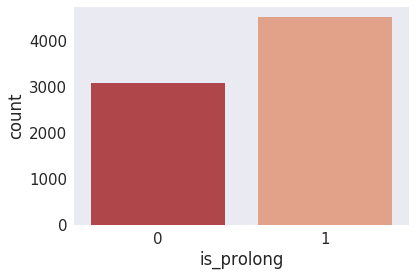

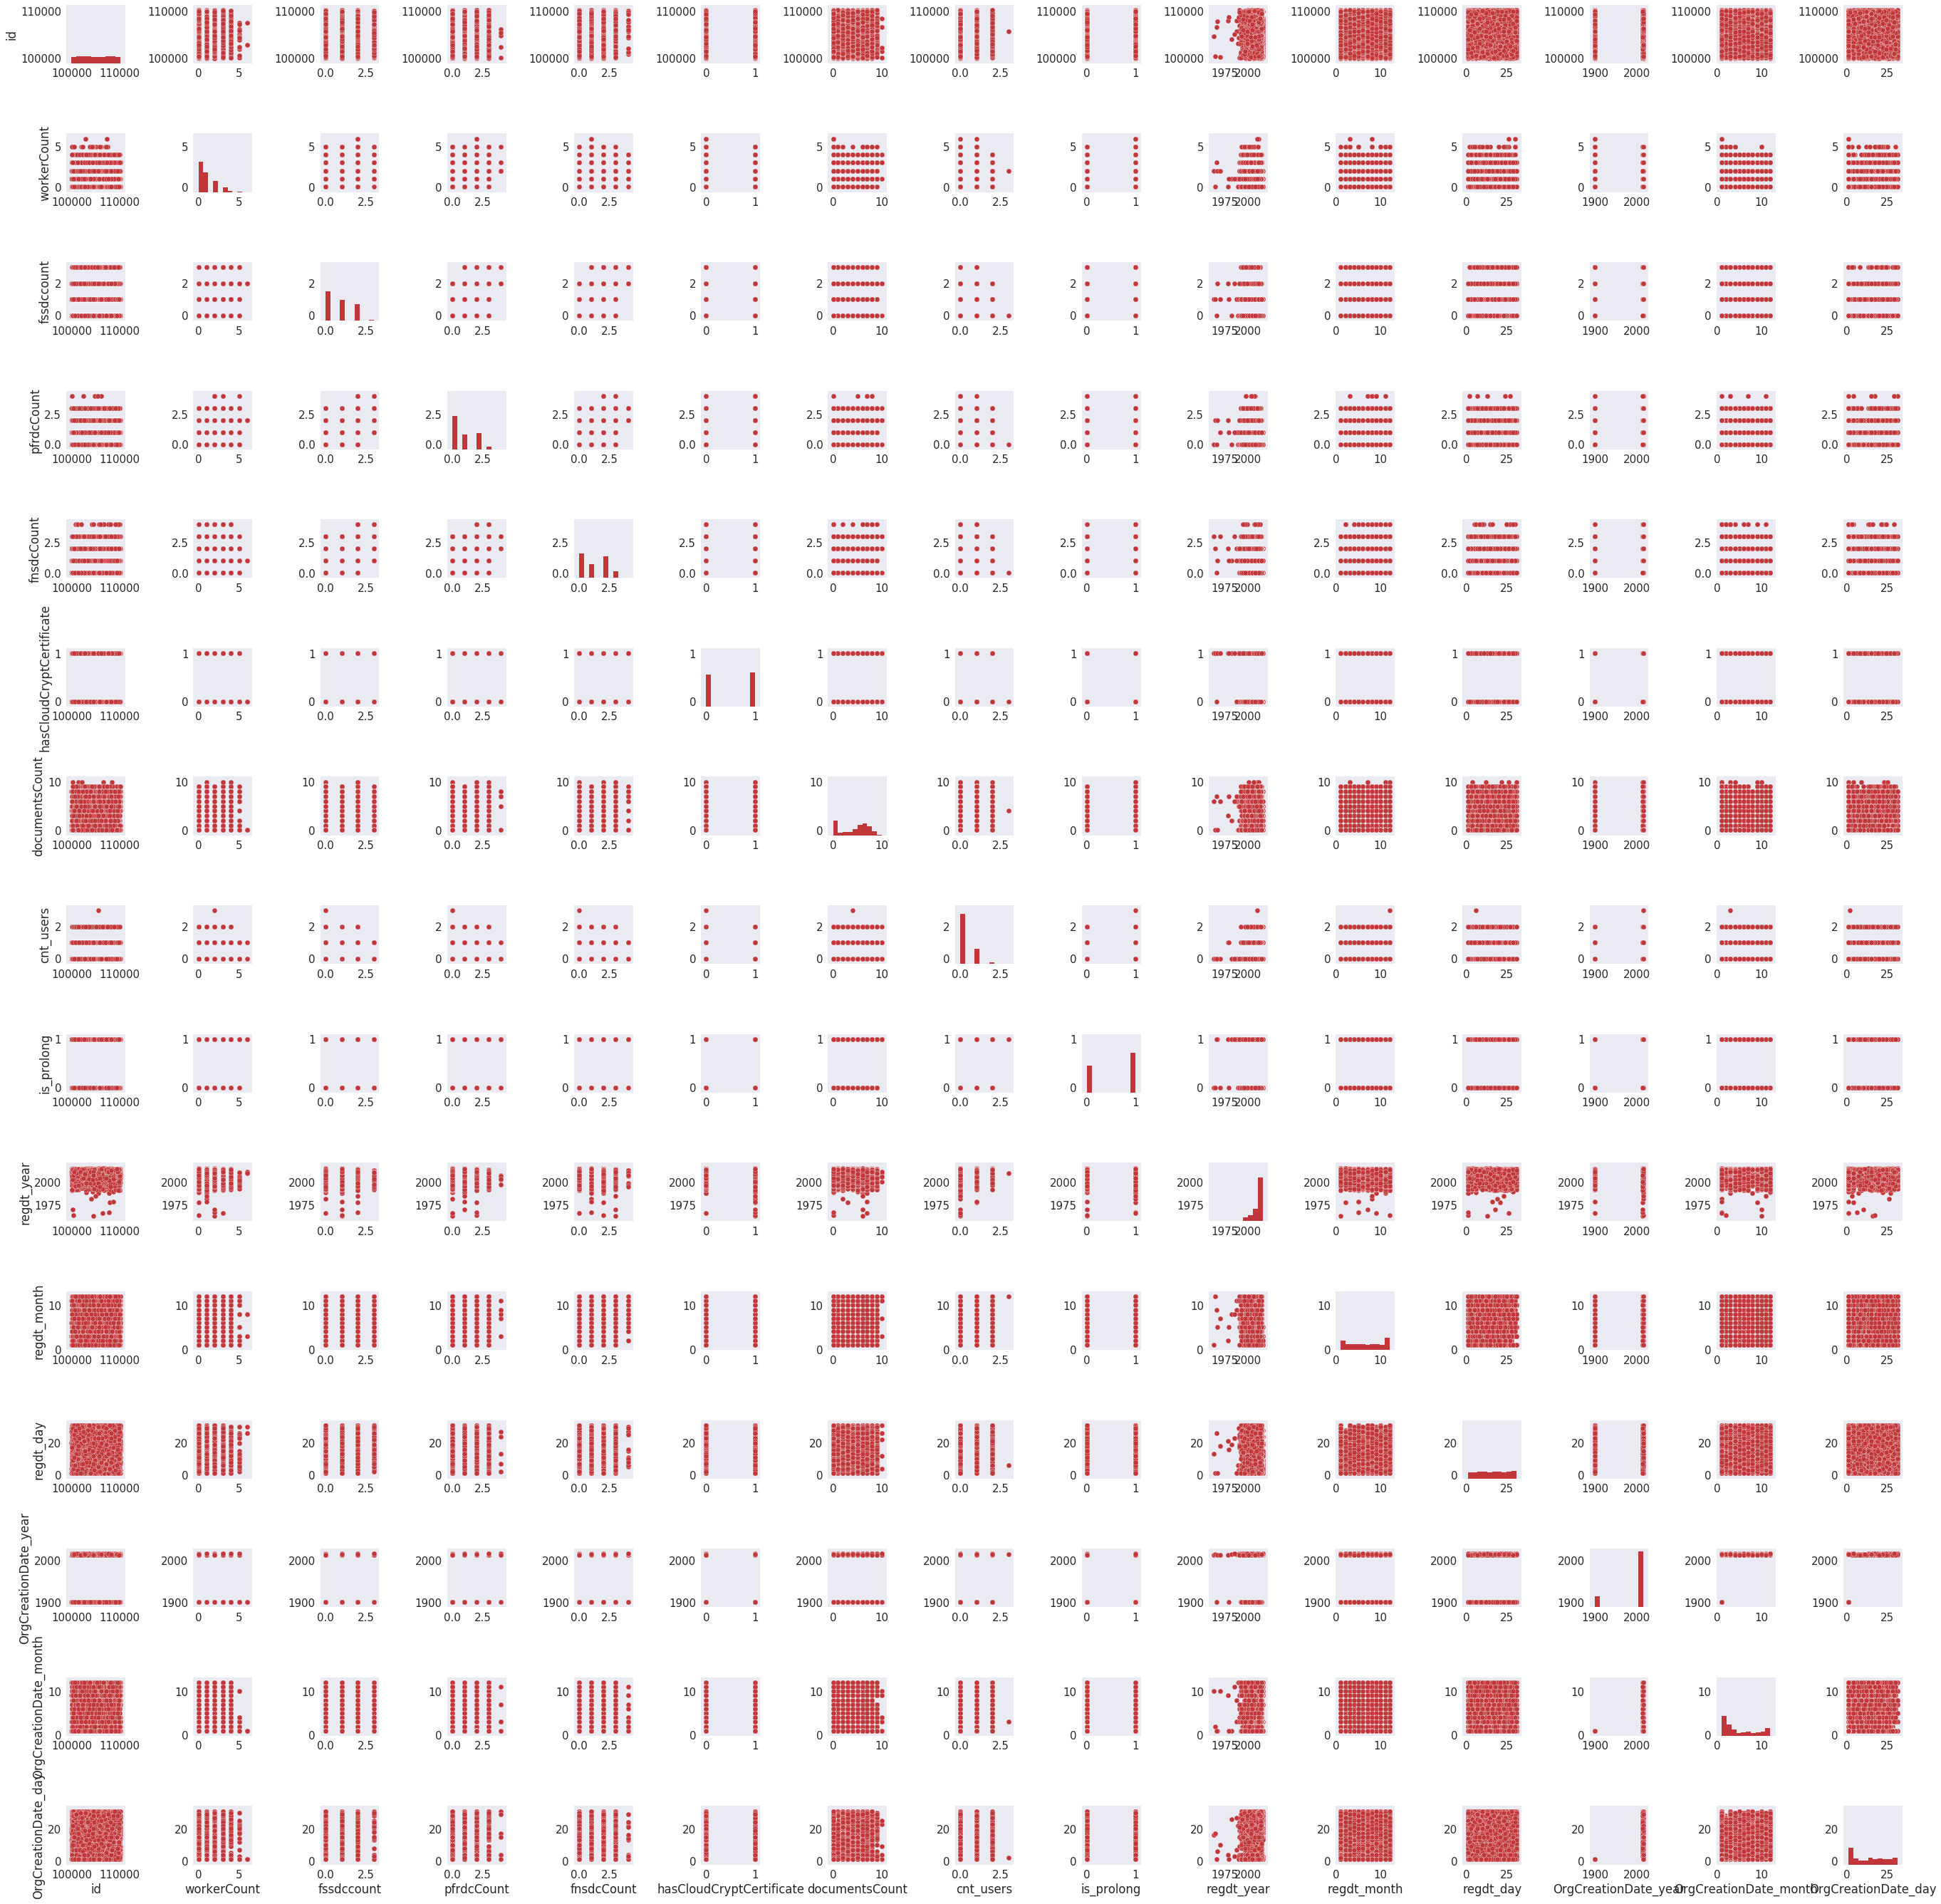

In [43]:
print 'Распределение целевой переменной: \t'
sns.countplot(train.is_prolong)

sns.pairplot(train)

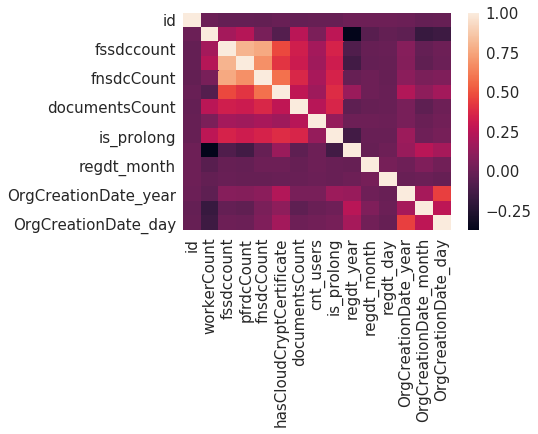

In [44]:
sns.heatmap(train.corr(method='spearman'));

In [6]:
target=train.is_prolong
train.drop(axis=1,columns=['is_prolong','id'],inplace=True)

## Label Encoding

{0: u'\u0415\u041d\u0412\u0414', 1: u'\u041e\u0421\u041d\u041e', 2: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 3%', 3: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 3% +\u0415\u041d\u0412\u0414', 4: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 4%', 5: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 6%', 6: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b 6% +\u0415\u041d\u0412\u0414', 7: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b \u0437\u0430 \u0432\u044b\u0447\u0435\u0442\u043e\u043c \u0440\u0430\u0441\u0445\u043e\u0434\u043e\u0432 10%', 8: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b \u0437\u0430 \u0432\u044b\u0447\u0435\u0442\u043e\u043c \u0440\u0430\u0441\u0445\u043e\u0434\u043e\u0432 10% +\u0415\u041d\u0412\u0414', 9: u'\u0423\u0421\u041d, \u0414\u043e\u0445\u043e\u0434\u044b \u0437\u0430 \u0432\u044b\u0447\u0435\u0442\u043e\u043c \u0440\u0430\u0441\u0445\u043e\u0434\u043e\u0432 12%', 10:

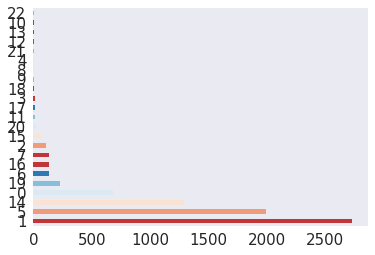

In [7]:
label_encoder = LabelEncoder()

mapped_education = pd.Series(label_encoder.fit_transform(train['taxactionSystem']))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [8]:
train['taxactionSystem'] = label_encoder.fit_transform(train['taxactionSystem']).astype('int')
train.head()

,taxactionSystem,workerCount,fssdccount,pfrdcCount,fnsdcCount,hasCloudCryptCertificate,documentsCount,cnt_users,regdt_year,regdt_month,regdt_day,OrgCreationDate_year,OrgCreationDate_month,OrgCreationDate_day
0,5,5,0,0,0,0,2,0,1994,3,26,2014,4,12
1,1,1,0,0,0,0,5,0,2012,12,5,2014,9,22
2,5,1,3,3,2,0,0,0,2009,11,15,2016,5,4
3,14,1,0,0,0,0,0,0,2015,8,9,2015,9,24
4,14,0,0,0,0,0,4,0,2015,3,29,2015,3,4


## Логистическая регрессия

In [9]:
train_X,test_X,train_y,test_y=train_test_split(train,target,shuffle=True,random_state=17,test_size=0.2)

In [11]:
from sklearn.pipeline import Pipeline

lr=LogisticRegression(n_jobs=4)
lr_pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(n_jobs=-1))])
lr_params = {'lr__C':np.logspace(-3, 1, 10)}
lr_grid = GridSearchCV(lr_pipe, lr_params,
                         cv=5, n_jobs=-1,
                        verbose=True)
lr_grid.fit(train_X, train_y)
lr_pred=lr_grid.predict(test_X)
print (lr_grid.best_params_, lr_grid.best_score_)
print accuracy_score(test_y, lr_pred)
print roc_auc_score(test_y, lr_pred)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
({'lr__C': 1.2915496650148828}, 0.75106943073379406)
0.767763157895
0.751332990258


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished


## Случайный лес

In [12]:
rnd_forest=RandomForestClassifier(n_jobs=-1)
forest_params = {'max_depth': range(7, 12)
                #,'max_features': range(5, len(train.columns), 1)
                ,'n_estimators':range(70,120,5)
                }
forest_grid=GridSearchCV(rnd_forest,forest_params,verbose=True,n_jobs=-1)
forest_grid.fit(train_X,train_y)
print (forest_grid.best_params_)

pred_forest=forest_grid.predict(test_X)
print (pred_forest[:10])
print (test_y[:10].values)
print accuracy_score(test_y,pred_forest)
print roc_auc_score(test_y, pred_forest)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   33.1s finished


{'n_estimators': 90, 'max_depth': 9}
[1 1 1 1 1 0 0 1 1 1]
[1 1 1 1 0 0 0 1 0 1]
0.805263157895
0.784888250388


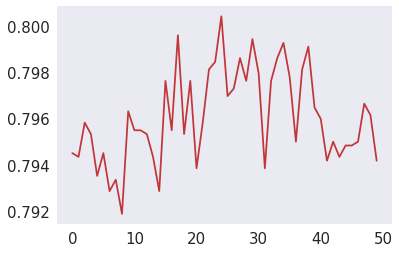

In [13]:
plt.plot(forest_grid.cv_results_['mean_test_score'])

## Градиентрный бустинг

In [14]:
g_boost=GradientBoostingClassifier()
boost_params = {'max_depth': range(5, 15)
              ,'n_estimators':range(70,120,5)}
boost_grid=GridSearchCV(g_boost,boost_params,verbose=True,n_jobs=-1)
boost_grid.fit(train_X,train_y)
print (boost_grid.best_params_)

pred_boost=boost_grid.predict(test_X)
print (pred_boost[:10])
print (test_y[:10].values)
print accuracy_score(test_y,pred_boost)
print roc_auc_score(test_y, pred_boost)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.8min finished


{'n_estimators': 70, 'max_depth': 6}
[1 1 1 1 1 0 0 1 1 1]
[1 1 1 1 0 0 0 1 0 1]
0.801315789474
0.784884676687


## xgboost

In [15]:
import xgboost as xgb
x_boost=xgb.XGBClassifier()
X_boost_params = {'max_depth': range(1, 10)
                ,'n_estimators':range(70,120,10)
                 ,'learning_rate':np.arange(0.01,0.1,0.02)}
x_boost_grid=GridSearchCV(x_boost,X_boost_params,verbose=True,n_jobs=-1)
x_boost_grid.fit(train_X,train_y)
print (x_boost_grid.best_params_)

pred_x_boost=x_boost_grid.predict(test_X)
print (pred_x_boost[:10])
print (test_y[:10].values)
print accuracy_score(test_y,pred_x_boost)

print roc_auc_score(test_y, pred_x_boost)

Fitting 3 folds for each of 225 candidates, totalling 675 fits


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 82.9min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed: 130.9min finished


{'n_estimators': 70, 'learning_rate': 0.069999999999999993, 'max_depth': 4}
[1 1 1 1 1 0 0 1 1 1]
[1 1 1 1 0 0 0 1 0 1]
0.797368421053
0.777458527207


## Метод ближайших соседей

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])
knn_params = {'knn__n_neighbors': range(1, 10)}
knn_grid = GridSearchCV(knn_pipe, knn_params,
                         cv=5, n_jobs=-1,
                        verbose=True)
knn_grid.fit(train_X, train_y)
print (knn_grid.best_params_, knn_grid.best_score_)
print accuracy_score(test_y, knn_grid.predict(test_X))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
({'knn__n_neighbors': 9}, 0.75534715366897009)
0.7875


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   10.9s finished


## Метрика

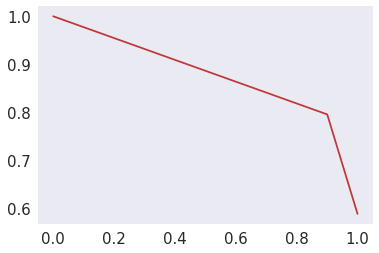

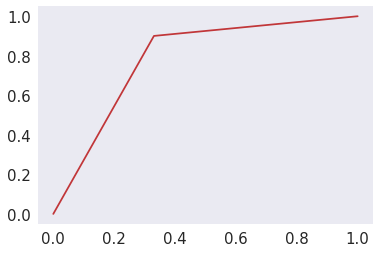

In [29]:
## Метрика
precision, recall, thresholds = precision_recall_curve(test_y, pred_forest)
plt.plot(recall,precision)

fpr, tpr, thresholds = roc_curve(test_y, pred_forest)
plt.figure()
plt.plot(fpr,tpr)